## Algoritmo de Precificação de imóveis

In [33]:
import numpy as np
import pandas as pd
import re
# disable chained assignments
pd.options.mode.chained_assignment = None 

## Leitura da base de dados

In [20]:
df_base = pd.read_json("assets/olx.json", orient="records", convert_dates=False)
df_base.head(3)

,_id,codigo,titulo,preco,data_publicacao,link,caracteristicas,descricao,created_at
0,{'$oid': '607458fa77dee513e95c7f1c'},749629484,Parque Alameda Real - Apartamento 2 quartos em...,R$ 138.900,12/04 às 11:19,https://se.olx.com.br/sergipe/imoveis/parque-a...,"{'categoria': 'Apartamentos', 'tipo': 'Venda -...",Código do anúncio: 3716\nParque Alameda Real |...,{'$date': '2021-04-12T14:28:10.612Z'}
1,{'$oid': '607458ff77dee513e95c7f1d'},868448367,::Ecoville park,R$ 330.000,12/04 às 10:48,https://se.olx.com.br/sergipe/imoveis/ecoville...,"{'categoria': 'Apartamentos', 'tipo': 'Venda -...",Ecoville park\n Localizado no bairro ponto no...,{'$date': '2021-04-12T14:28:14.990Z'}
2,{'$oid': '6074590377dee513e95c7f1e'},868448657,::Ecoville park,R$ 330.000,12/04 às 10:49,https://se.olx.com.br/sergipe/imoveis/ecoville...,"{'categoria': 'Apartamentos', 'tipo': 'Venda -...",Ecoville park\n Localizado no bairro ponto no...,{'$date': '2021-04-12T14:28:19.357Z'}


## Tratamento dos dados

In [68]:
df2 = pd.DataFrame(df_base.caracteristicas.apply(pd.Series))
df = pd.concat([df_base, df2], axis=1)

campos_numericos = ['preco', 'area_util', 'banheiros', 'quartos', 'vagas_na_garagem']
campos_categoricos = ['bairro']

for campo in campos_numericos:
    df[campo] = df[campo].apply(str).apply(lambda x: re.sub('[^0-9]', '', x))
    df[campo] = df[campo].apply(lambda x: 0 if x == '' else x).astype(float)
    df[campo] = df[campo].astype(float)
    
df['preco'] = df['preco'].apply(lambda x: x*100 if x < 1000 else x)
df['preco'] = df['preco'].apply(lambda x: x/1000 if x > 50000000 else x)

df = df[campos_numericos + campos_categoricos]

## Preenchendo valores vazios com a mediana

In [69]:
df = df.replace(to_replace=0.0, value=df.median(), method='ffill')
df.head(3)

,preco,area_util,banheiros,quartos,vagas_na_garagem,bairro
0,138900.0,40.0,2.0,3.0,1.0,Santa Maria
1,330000.0,62.0,2.0,3.0,1.0,Jardins
2,330000.0,62.0,2.0,3.0,1.0,Jardins


## Separando a base entre Treino e Teste

In [70]:
from sklearn.model_selection import train_test_split

df_treino, df_test = train_test_split(df, test_size=0.3, random_state=2)

## Tratando váriaveis categóricas

In [71]:
from category_encoders import OrdinalEncoder
enc = OrdinalEncoder(cols=campos_categoricos)
enc.fit(df[campos_categoricos]);

/opt/conda/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


## Treinando Modelos

In [72]:
def treina_modelo(modelo, df, colunas, objetivo):
    X = df[colunas]
    y = df[objetivo]

    modelo.fit(X,y)
    return modelo

In [73]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

modelo_1 = LinearRegression(n_jobs=-1)
modelo_2 = RandomForestRegressor(n_jobs=-1, random_state=0)
modelo_3 = LGBMRegressor(objective='regression', random_state=0)

objetivo = 'preco'
if objetivo in campos_numericos:
    campos_numericos.remove(objetivo)
df_treino[campos_categoricos] = enc.transform(df_treino[campos_categoricos])

model_1_treinado = treina_modelo(modelo_1, df_treino, campos_numericos + campos_categoricos, objetivo)
model_2_treinado = treina_modelo(modelo_2, df_treino, campos_numericos + campos_categoricos, objetivo)
model_3_treinado = treina_modelo(modelo_3, df_treino, campos_numericos + campos_categoricos, objetivo)

## Aplicando modelos treinados

In [74]:
df_test[campos_categoricos] = enc.transform(df_test[campos_categoricos])
X_prev = df_test[campos_numericos + campos_categoricos]

In [75]:
df_test['previsao_modelo_1'] = np.round(model_1_treinado.predict(X_prev))
df_test['previsao_modelo_2'] = np.round(model_2_treinado.predict(X_prev))
df_test['previsao_modelo_3'] = np.round(model_3_treinado.predict(X_prev))

## Avaliando erro

In [76]:
from math import sqrt
from sklearn.metrics import mean_squared_error

def obter_erro_modelo(df_test, coluna_prev):
    df_test[coluna_prev + '_err_abs'] = np.abs(df_test[coluna_prev] - df_test['preco'])
    df_test[coluna_prev + '_err_rel'] = np.round(df_test[coluna_prev + '_err_abs']/df_test['preco'], 2)
    
def aplica_rmse(df, esperado, previsto):
    return sqrt(mean_squared_error(df[esperado], df[previsto]))

In [77]:
obter_erro_modelo(df_test, 'previsao_modelo_1')
obter_erro_modelo(df_test, 'previsao_modelo_2')
obter_erro_modelo(df_test, 'previsao_modelo_3')

In [78]:
df_test[['preco', 'previsao_modelo_1', 'previsao_modelo_1_err_abs', 'previsao_modelo_1_err_rel']]
aplica_rmse(df_test, 'preco', 'previsao_modelo_1'), df_test['previsao_modelo_1_err_rel'].median(), df_test['previsao_modelo_1_err_rel'].mean()

(208142.6787073563, 0.24, 0.6195341207349082)

In [79]:
df_test[['preco', 'previsao_modelo_2', 'previsao_modelo_2_err_abs', 'previsao_modelo_2_err_rel']]
aplica_rmse(df_test, 'preco', 'previsao_modelo_2'), df_test['previsao_modelo_2_err_rel'].median(), df_test['previsao_modelo_2_err_rel'].mean()

(139858.24861881798, 0.1, 0.32439632545931757)

In [80]:
df_test[['preco', 'previsao_modelo_3', 'previsao_modelo_3_err_abs', 'previsao_modelo_3_err_rel']]
aplica_rmse(df_test, 'preco', 'previsao_modelo_3'), df_test['previsao_modelo_3_err_rel'].median(), df_test['previsao_modelo_3_err_rel'].mean()

(149379.30108660978, 0.12, 0.4122900262467191)

## Gráficos de Erro
### Raiz quadrada do erro-médio (RMSE)
### Mediana do erro relativo 
### Média do erro relativo

In [81]:
def obter_erros_grafico(df, coluna_previsao, nome_modelo):
#     rmse = aplica_rmse(df, 'preco', coluna_previsao)
    mediana = df_test[coluna_previsao+'_err_rel'].median()
    media = df_test[coluna_previsao+'_err_rel'].mean()
#     return [[rmse, 'rmse', nome_modelo], [mediana, 'mediana', nome_modelo], [media, 'media', nome_modelo]]
    return [[mediana, 'mediana', nome_modelo], [media, 'media', nome_modelo]]

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

array_erros = (obter_erros_grafico(df_test, 'previsao_modelo_1', 'RL') + 
               obter_erros_grafico(df_test, 'previsao_modelo_2', 'RFA') + 
               obter_erros_grafico(df_test, 'previsao_modelo_3', 'LGBM'))

dados_erros = pd.DataFrame(np.array(array_erros), columns=['erro', 'metrica', 'modelo'])
dados_erros['erro'] = dados_erros['erro'].astype(float)
dados_erros

,erro,metrica,modelo
0,0.240000,mediana,RL
1,0.619534,media,RL
2,0.100000,mediana,RFA
3,0.324396,media,RFA
4,0.120000,mediana,LGBM
5,0.412290,media,LGBM


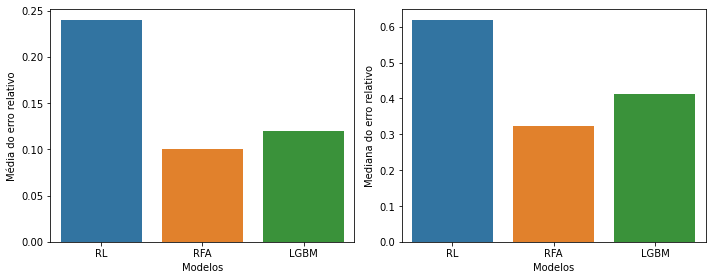

In [83]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

# g = sns.barplot(x='modelo',
#                  y='erro',
#                  data=dados_erros[dados_erros['metrica'] == 'rmse'],
#                  ax=axes[0])
# g.set(xlabel='Modelos', ylabel='RMSE')

g = sns.barplot(x='modelo',
                 y='erro',
                 data=dados_erros[dados_erros['metrica'] == 'mediana'],
                 ax=axes[0])
g.set(xlabel='Modelos', ylabel='Média do erro relativo')

g = sns.barplot(x='modelo',
                 y='erro',
                 data=dados_erros[dados_erros['metrica'] == 'media'],
                 ax=axes[1])
g.set(xlabel='Modelos', ylabel='Mediana do erro relativo')

plt.tight_layout()
plt.show()

## Aplicando o modelo na base completa

In [20]:
modelo = RandomForestRegressor(n_jobs=-1, random_state=0)
df_final = df.copy()

objetivo = 'preco'
if objetivo in campos_numericos:
    campos_numericos.remove(objetivo)
df_final[campos_categoricos] = enc.transform(df_final[campos_categoricos])

model_treinado = treina_modelo(modelo, df_final, campos_numericos + campos_categoricos, objetivo)

df_final['valor_precificacao'] = np.round(model_treinado.predict(df_final[campos_numericos + campos_categoricos]))
df_final

,preco,area_util,banheiros,quartos,vagas_na_garagem,bairro,valor_precificacao
0,138900.0,40.0,2.0,3.0,1.0,1,143199.0
1,330000.0,62.0,2.0,3.0,1.0,2,369677.0
2,330000.0,62.0,2.0,3.0,1.0,2,369677.0
3,200001.0,61.0,2.0,2.0,1.0,3,200004.0
4,330000.0,62.0,2.0,3.0,1.0,2,369677.0
...,...,...,...,...,...,...,...
5074,220000.0,78.0,1.0,3.0,1.0,9,243852.0
5075,280050.0,123.0,3.0,4.0,1.0,8,280028.0
5076,98000.0,62.0,1.0,2.0,1.0,28,112142.0
5077,268509.0,64.0,2.0,3.0,1.0,16,225614.0


In [21]:
obter_erro_modelo(df_final, 'valor_precificacao')
df_final.valor_precificacao_err_rel.median(), df_final.valor_precificacao_err_rel.mean()

(0.06, 0.4194132703288048)

In [22]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(df_final['preco'], df_final['valor_precificacao']))

In [23]:
rmse

4453598.4603293305